<a href="https://colab.research.google.com/github/alanbseo/MFAworkshop/blob/main/MFA_2_MaterialIntensity_EmbeddedCarbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이 노트북에서는 지난 번 코드에서 전처리한 자료를 읽어서 MI와 Embedded Carbon을 계산해 보도록 합시다.

## Colab 기본 설정


In [3]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np


# import pandas and geopandas package
import pandas as pd

try:
  import geopandas as gpd
except: # 설치되어 있지 않을 경우 이리로 분기하여 패키지를 설치
  !pip install geopandas 
  import geopandas as gpd

# import rasterio pacakge 
try:
  import rasterio
except:
  !pip install rasterio
  import rasterio

# import required functions
from rasterio import transform
from rasterio import features
from rasterio.enums import Resampling


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 104.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.4 MB/s eta 0:00:00


In [12]:
# Mount Gdrive 
from google.colab import drive

if not (os.path.exists('/content/gdrive/')):
  print("Mount Gdrive")
  drive.mount('/content/gdrive/')


# set working directory
default_path = '/content/gdrive/MyDrive/Net zero built environment/MFA workshop' # 이 경로는 사용자 마다 상이할 수 있음
 
print("Change working directory to the Google Drive folder")
os.chdir(default_path) 
print(os.getcwd()) # print the current working directory


Change working directory to the Google Drive folder
/content/gdrive/.shortcut-targets-by-id/1gDT-7hKMl37JnTVecJLmI9yB2rUI7rAo/Net zero built environment/MFA workshop


## 지난 시간에 만든 건축물 용적(volume)과 구조코드를 읽어들이자. 

In [16]:
# Read the rasterised Volume and Code data 
volume_out_fn = './images/volume_100m.tif'
code_out_fn = './images/code_100m.tif'


# 해당 파일이 없을 경우 에러가 발생하고, 그럴 때는 images 폴더 안에 해당 파일을 복사해 넣어야 함. 
with rasterio.open(volume_out_fn) as src:
    print(src.__class__) 
    print(src.profile) # meta information 출력
    volume_img = src.read(1)  # 읽어들인 이미지는 rasterio 패키지의 DatasetReader클래스인데, 
                              # 우리는 ndarray 형태의 자료만 사용


with rasterio.open(code_out_fn) as src:
    print(src.profile)
    code_img = src.read(1) 



<class 'rasterio.io.DatasetReader'>
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 67, 'height': 75, 'count': 1, 'crs': CRS.from_epsg(5179), 'transform': Affine(100.0, 0.0, 951300.0,
       0.0, -100.0, 1959400.0), 'blockysize': 15, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 67, 'height': 75, 'count': 1, 'crs': CRS.from_epsg(5179), 'transform': Affine(100.0, 0.0, 951300.0,
       0.0, -100.0, 1959400.0), 'blockysize': 75, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [15]:
 ## Print the class name 
volume_img.__class__ #  ndarray object. 
# code_img.__class__ #   ndarray object. 
 

numpy.ndarray

Text(0, 0.5, 'Row #')

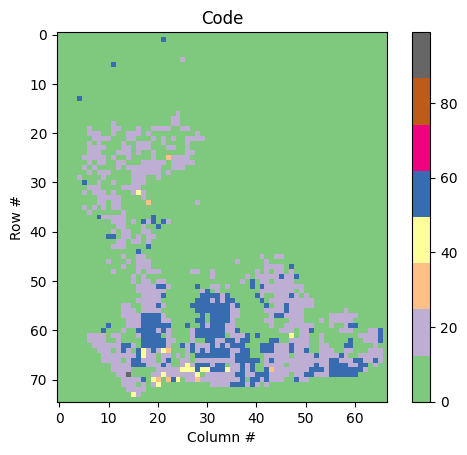

In [ ]:
# plot the sturctural code data
plt.imshow(code_img, cmap='Accent')
plt.colorbar()
plt.title('Code')
plt.xlabel('Column #')
plt.ylabel('Row #')

구조 코드별로 건축물 용적을 나누고, MI 원단위를 적용

In [ ]:
# Dimension
code_img.shape  # 75 x 67 

# Frequency table
unique, counts = np.unique(code_img, return_counts=True)
print(dict(zip(unique, counts)))

### 
# 0: NA
# 11: Brick
# 12: Block
# 19: Other masonry structure (기타조적구조)
# 21: Reinforced concrete
# 31: Steel (일반철골구조)
# 40: Steel reinforced concrete
# 41: Steel concrete (철골콘크리트)
# 42: Steel reinforced concrete (== 40?)
# 51: Wood (일반목구조)
# 99: Other 


{0: 3714, 11: 327, 12: 22, 19: 1, 21: 676, 31: 7, 40: 1, 41: 1, 42: 16, 51: 259, 99: 1}


In [ ]:



# Volume by Structure
volume_21 = volume_img * (code_img == 21) 

print(np.nansum(volume_21))

print("Total Volume (All structure) = " + str(np.nansum(volume_img)) + " (m3)")  # total volume (m3)
print("Total Volume (Reinforced concerete; Code=11) = " + str(np.nansum(volume_21)) + " (m3")  # only for Code=11 (m3)

# code_img.Series(x)
#print(dict(code_img.Series(x).value_counts()))



# code_img.df1.State.value_counts()

6828949.699500001
Total Volume (All structure) = 13053692.031499999 (m3)
Total Volume (Reinforced concerete; Code=11) = 6828949.699500001 (m3


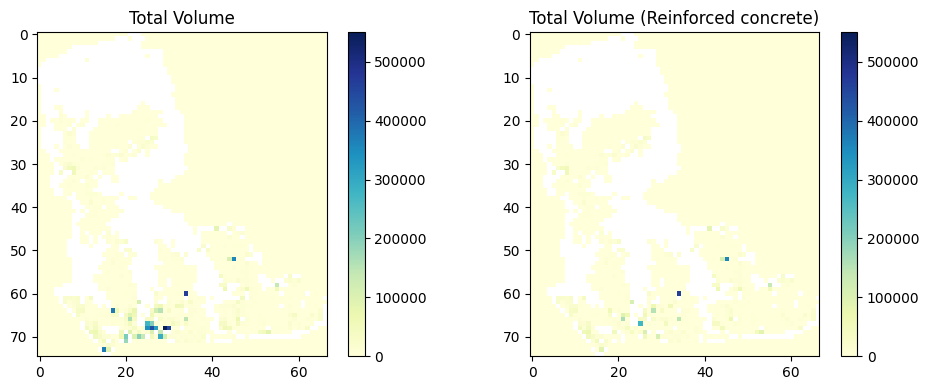

In [ ]:
nrow = 1
ncol = 2


plt.figure(figsize=(10,4))
plt.subplot(nrow, ncol, 1)
plt.imshow(volume_img,  cmap='YlGnBu', vmin=0, vmax=5.5E5)
plt.colorbar()
plt.title('Total Volume')

plt.subplot(nrow, ncol, 2)
plt.imshow(volume_21,  cmap='YlGnBu', vmin=0, vmax=5.5E5)
plt.colorbar()
plt.title('Total Volume (Reinforced concrete)')


plt.tight_layout()
plt.show()



In [ ]:
# Read MI table

# 이름으로 불러오기
# pd.read_excel('경로/파일명.xlsx', sheet_name = '시트명')
pd.read_excel('Data/MI by structure_v1.xlsx', sheet_name = 'MI')

ValueError: ignored

MI와 Embedded Carbon사이의 관계식을 엑셀에서 읽어들이고 내재탄소량 계산

MI와 내재탄소량 플로팅